# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# Новый раздел

# 4. Домашнее задание
***

In [ ]:
!conda install missingno --yes

In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_mpi = pd.read_csv("kiva_mpi_region_locations.csv")
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders'] ]


## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

# 4.1.1
А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

In [42]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'female'])[-20:]

df_gender_by_country_male = df_gender_by_country[['male', 'female', 'group']]

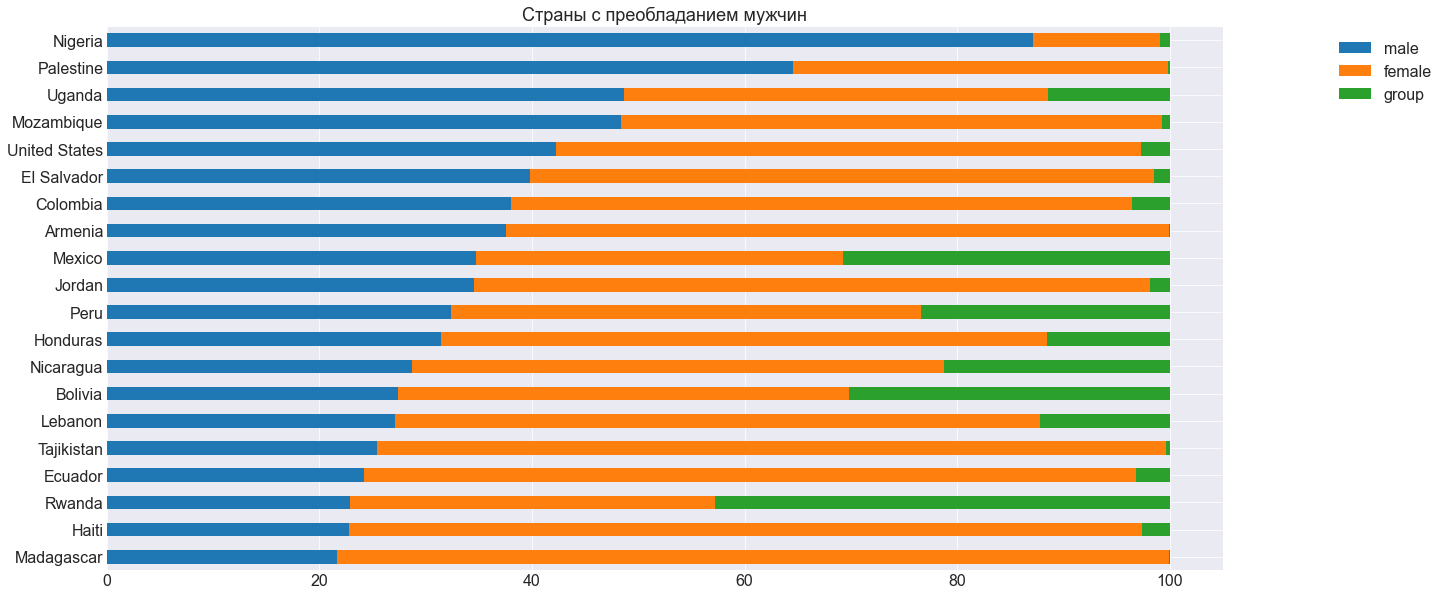

In [43]:
plot = df_gender_by_country_male.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Страны с преобладанием мужчин')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [5]:

df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group', 'female'])[-20:]

df_gender_by_country_group = df_gender_by_country[['group', 'female', 'male']]

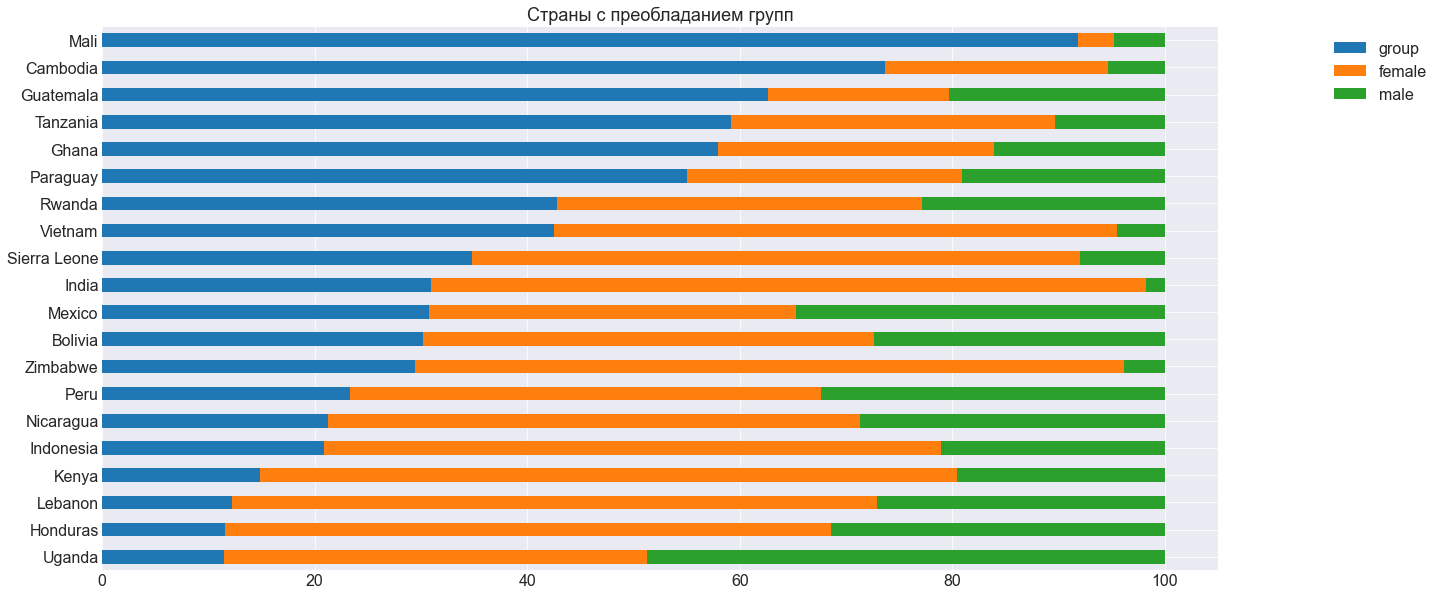

In [6]:
plot = df_gender_by_country_group.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Страны с преобладанием групп')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

# 4.1.2
Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [34]:
df_kiva_loans_sort = df_kiva_loans.sort_values(by='loan_amount', ascending=False)
df_kiva_loans_sort = df_kiva_loans_sort.head(16)


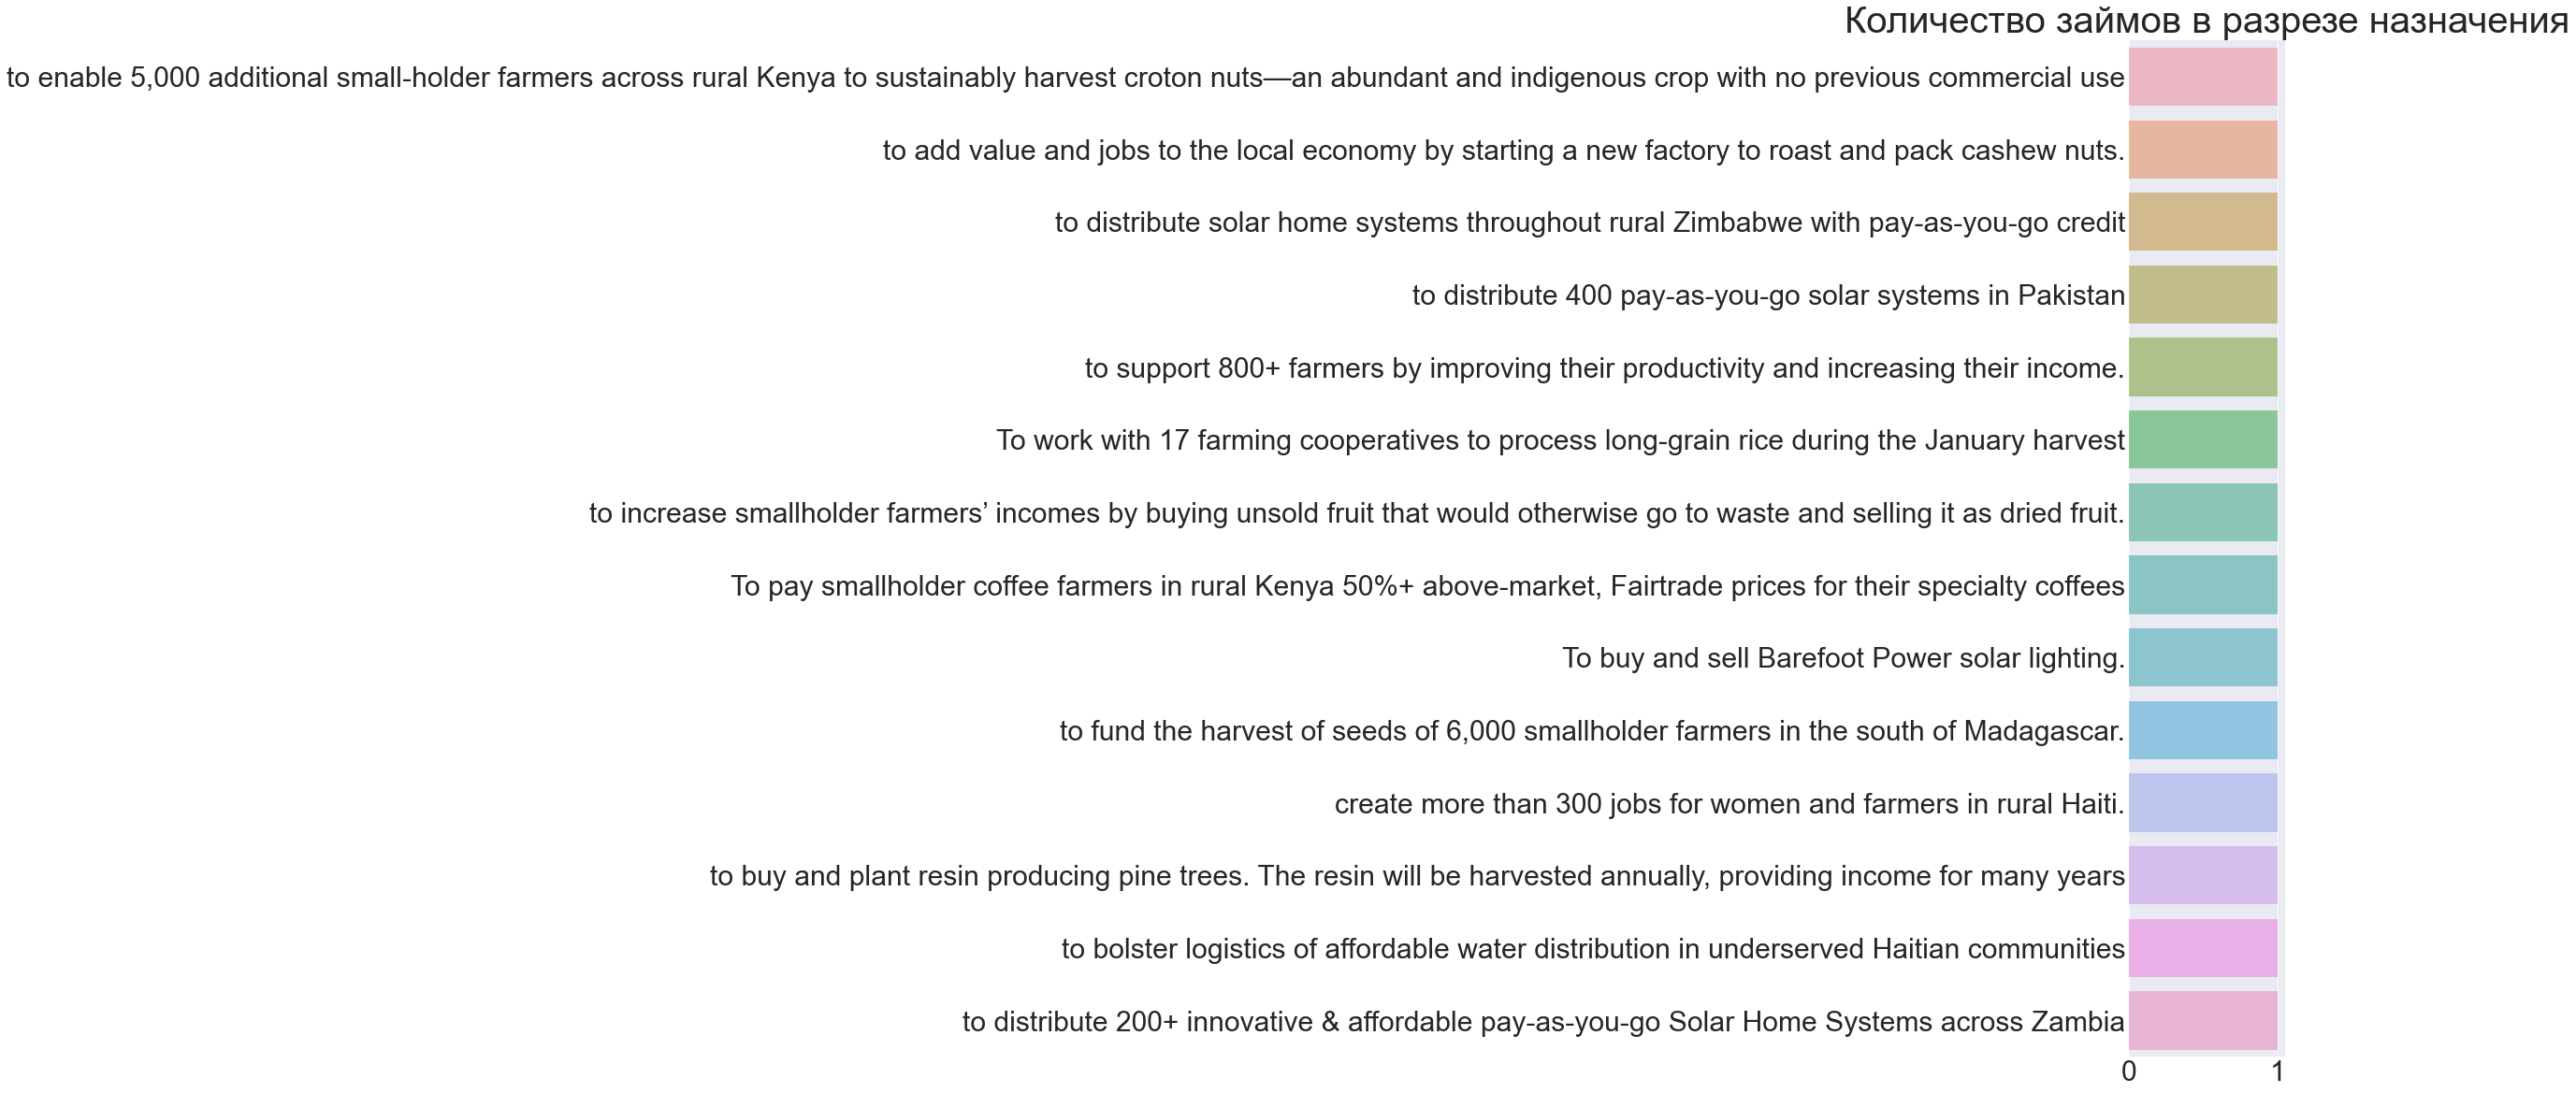

Количество  значений столбца "use":  14


In [8]:
use = df_kiva_loans_sort['use'].value_counts()

plt.figure(figsize=(3,20))
plt.title("Количество займов в разрезе назначения", fontsize=40)
plt.tick_params(labelsize=30)

sns.barplot(y=use.index, x=use.values, alpha=0.6)
plt.show()

print('Количество  значений столбца "use": ', df_kiva_loans_sort['use'].count())

Заявки с очень большими суммами приходятся в основном на сельскохозяйственные нужды и только одна на распространение домашних солнечных батарей.

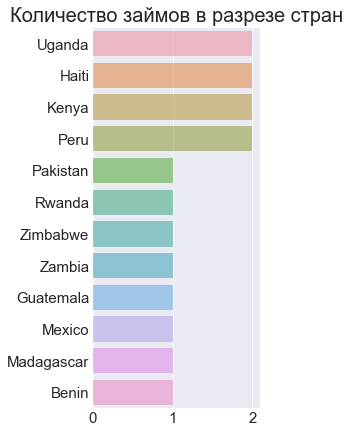

In [9]:
country = df_kiva_loans_sort['country'].value_counts()

plt.figure(figsize=(3,7))
plt.title("Количество займов в разрезе cтран", fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(y=country.index, x=country.values, alpha=0.6)
plt.show()

Также в разрезе стран наибольшие заявки выданы по одной-две на каждую страну. Среди этих стран находятся беднейшие страны.

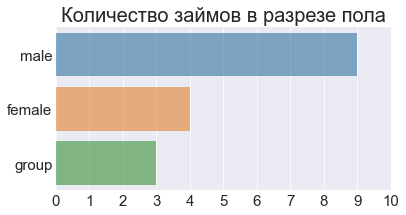

In [10]:
borrower_genders = df_kiva_loans_sort['borrower_genders'].value_counts()

plt.figure(figsize=(6,3))
plt.title("Количество займов в разрезе пола", fontsize=20)
plt.tick_params(labelsize=15)

sns.barplot(y=borrower_genders.index, x=borrower_genders.values, alpha=0.6)
plt.xticks(np.arange(0, 11, 1))
plt.show()

По гендерному составу подавляющее число заявок(9 из 16) выдано мужчинам

# 4.1.3
Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [37]:
df_mpi_region = df_mpi[['country', 'world_region']]
df_kiva_region = df_kiva_loans[['country', 'borrower_genders', 'loan_amount']]
df_kiva_region = df_kiva_region.merge(df_mpi_region, how='left', on='country')


In [38]:
region_gender_loans = \
    df_kiva_region.groupby(['world_region', 'borrower_genders'])['loan_amount']\
    .count()\
    .reset_index()


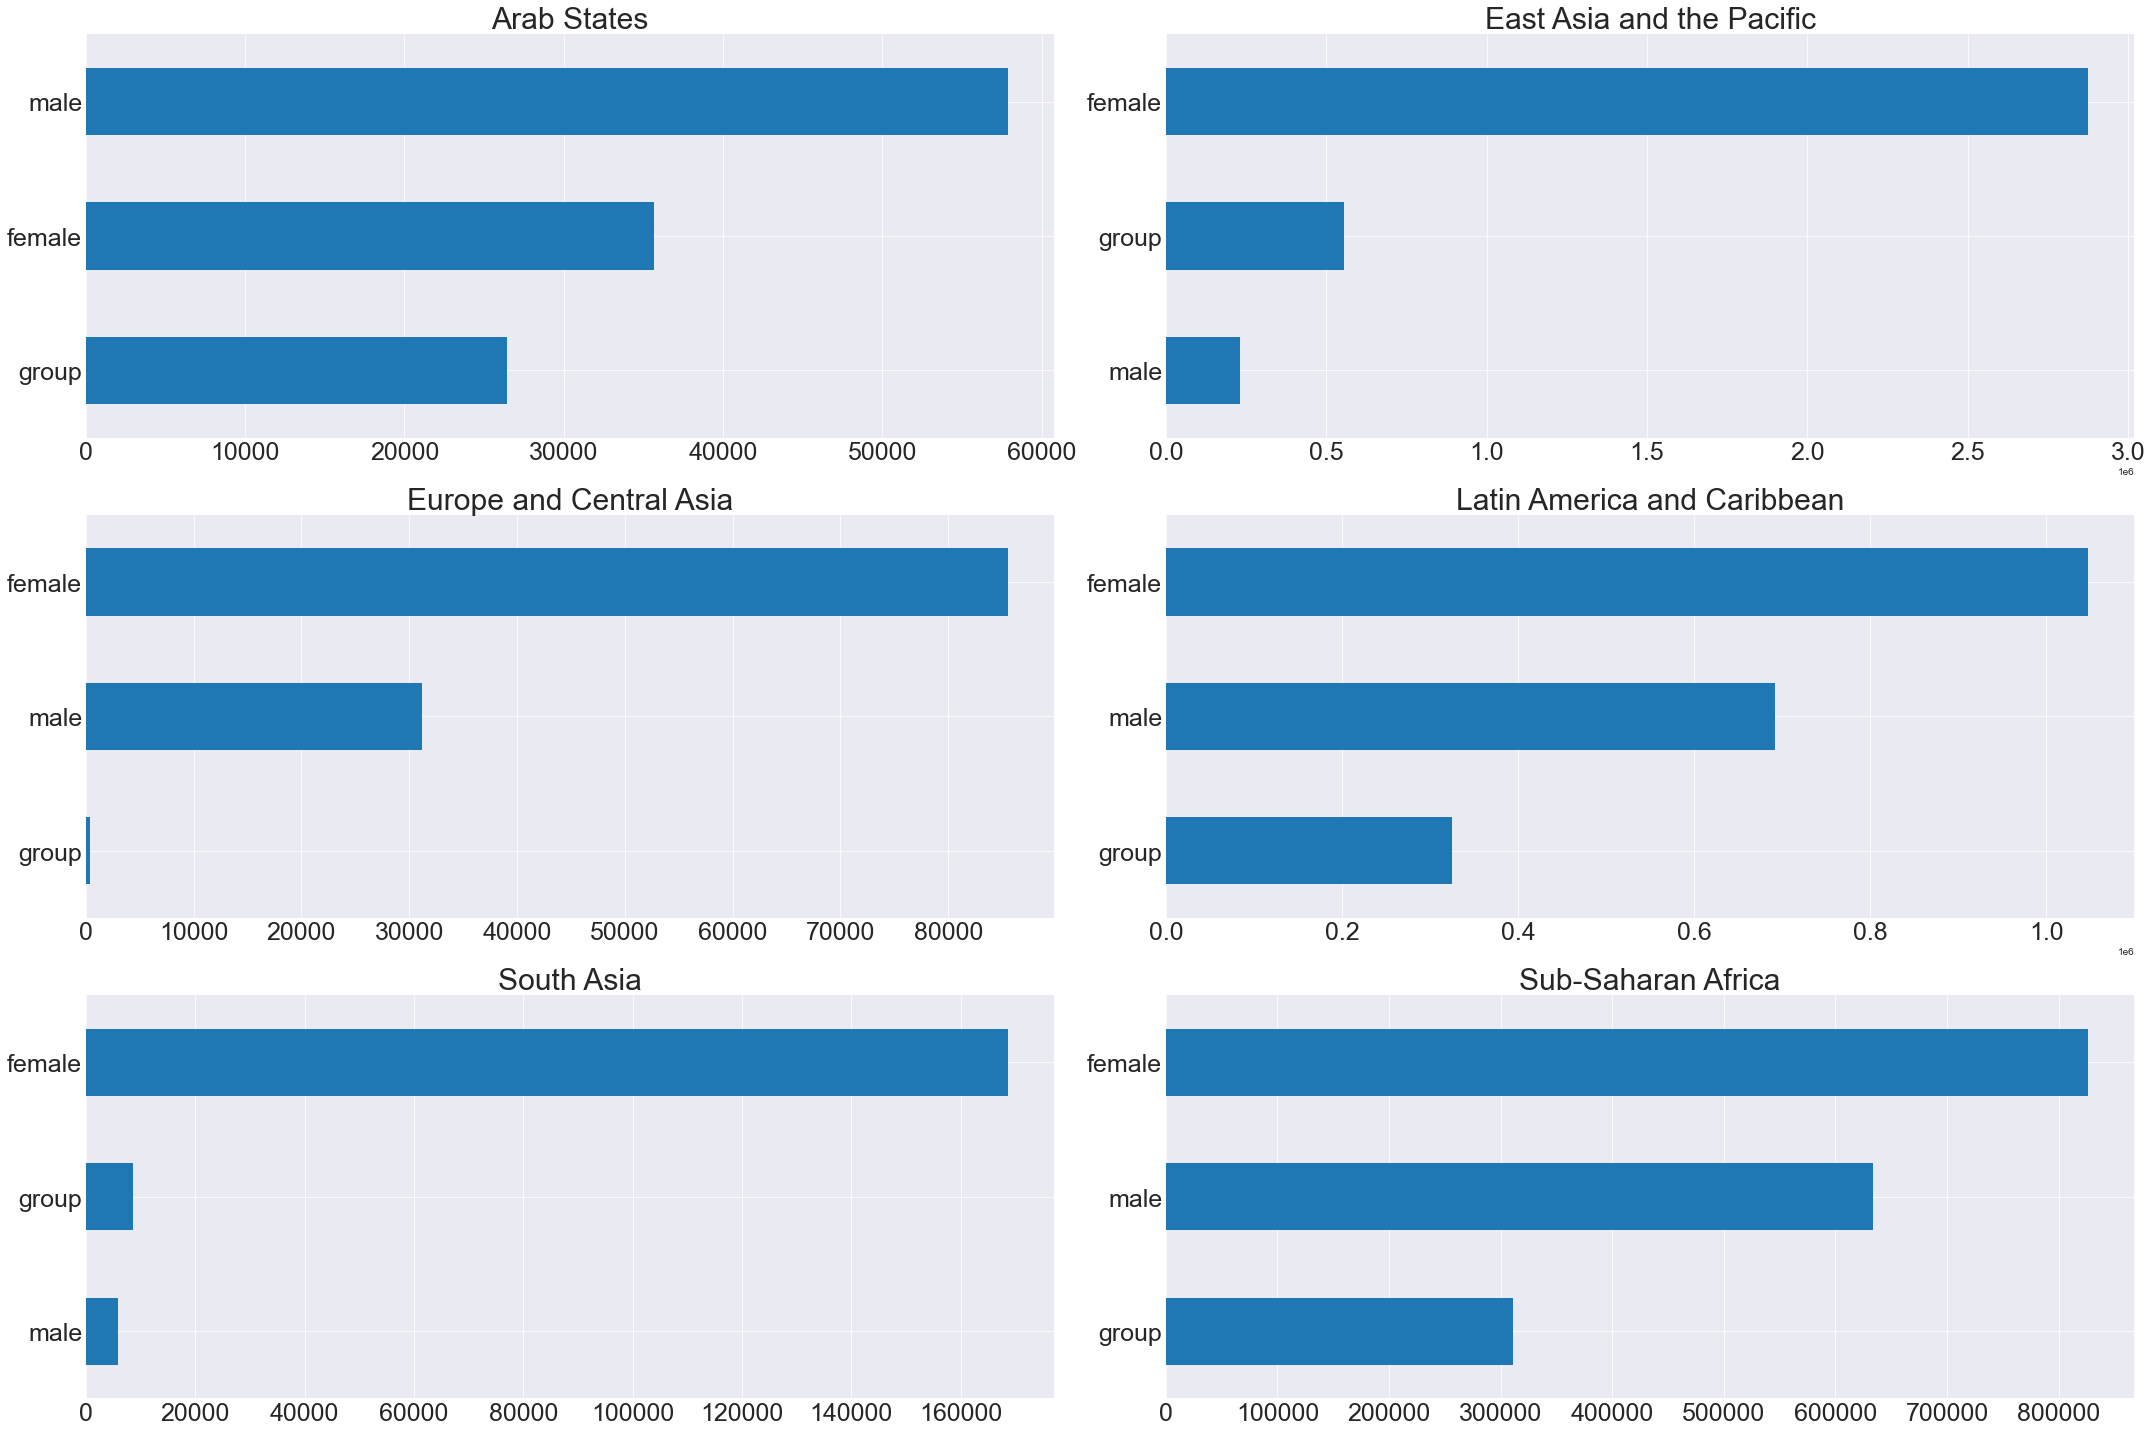

In [39]:
fig,axes = plt.subplots(3,2, sharex=False, squeeze=False, figsize=(30,20))

for ax,q in zip(axes.ravel(), region_gender_loans.world_region.unique()):
    tmp_df = region_gender_loans[region_gender_loans.world_region.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-3:]
    ax.set_title(q, fontsize=30)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='borrower_genders', ax=ax, legend=None, fontsize=25)

Из графиков видно, что практически во всех регионах(кроме арабского) большие суммы заявок получают женщины, но из предыдущего 
исследования мы видели, что исключительно большие займы выдаются мужчинам.

## 4.2. Домашняя работа
***

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

# 4.2.1
Рассмотрим зависимость пола заемщика от региона планеты и сектора экономики

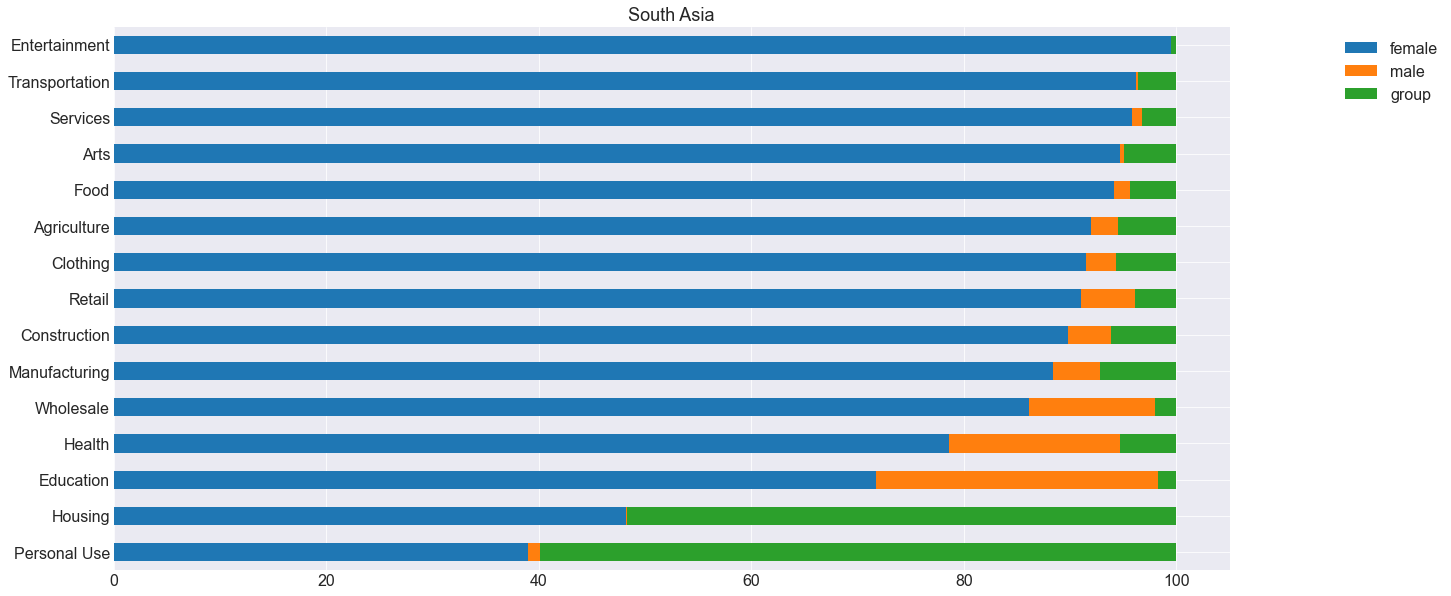

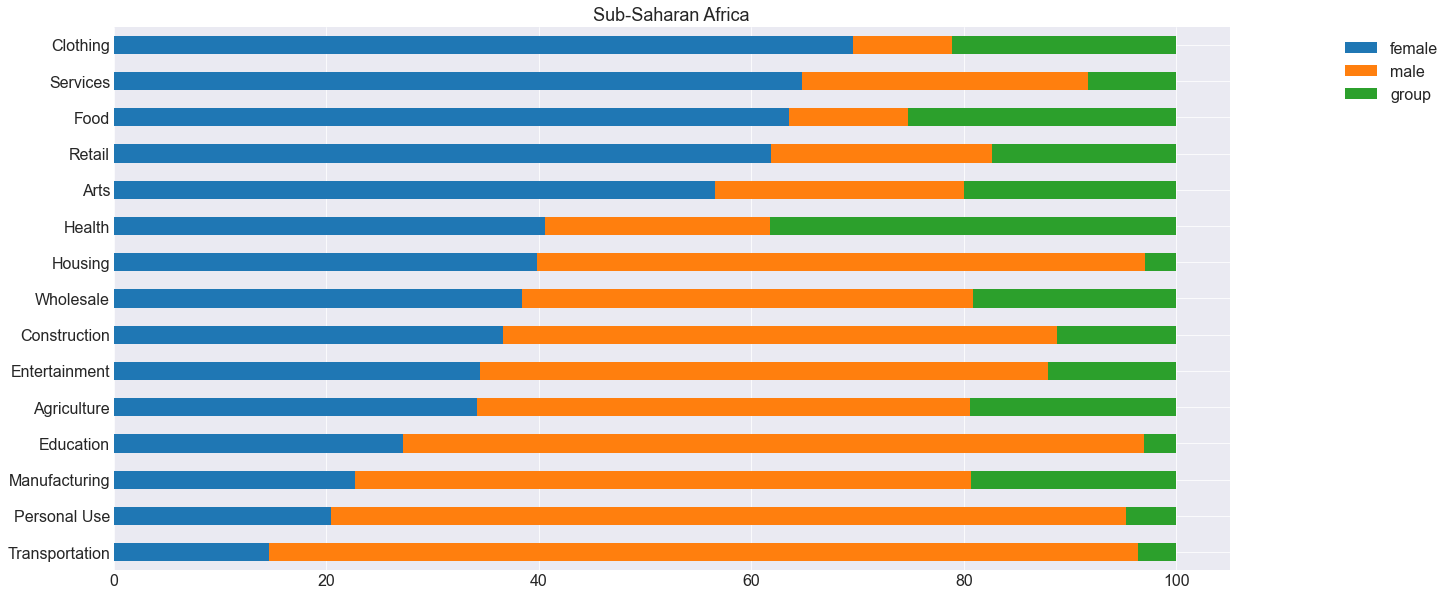

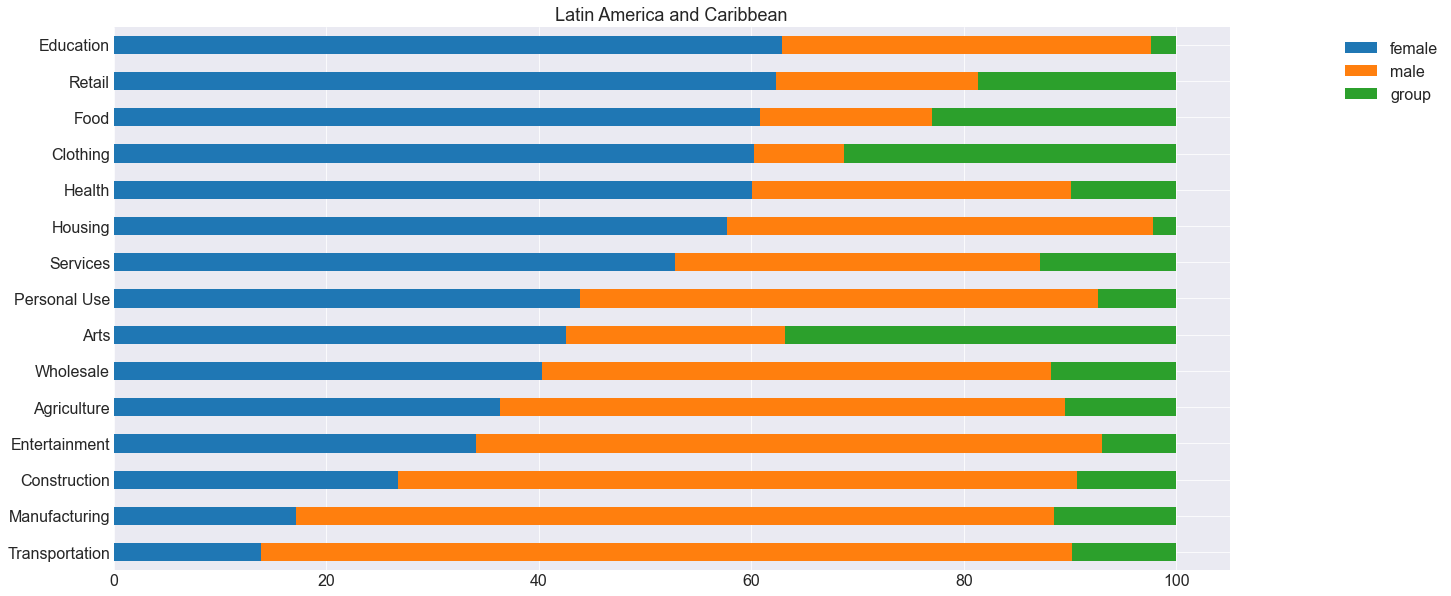

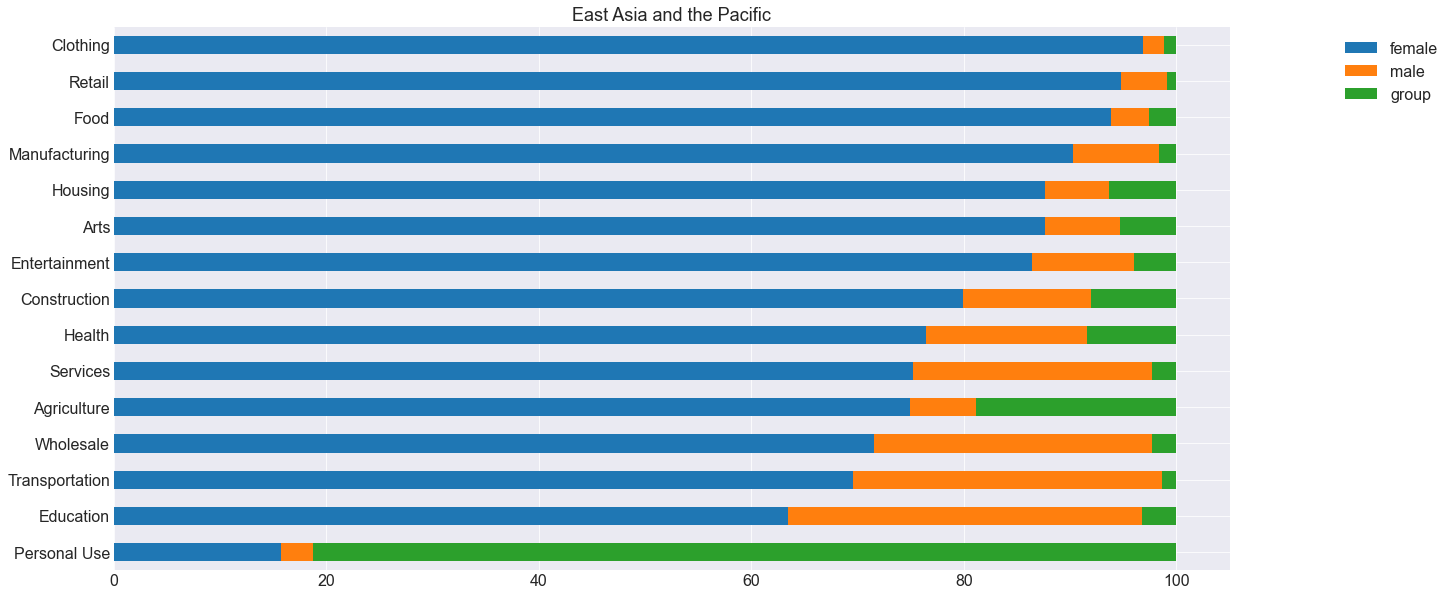

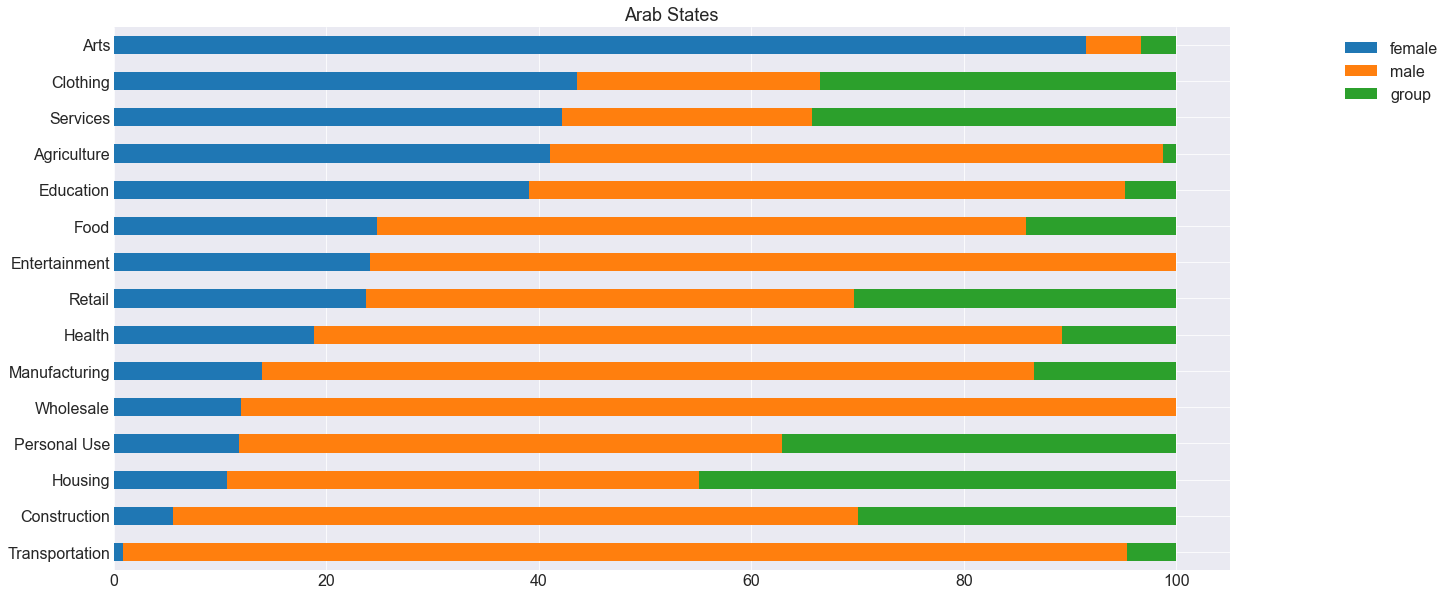

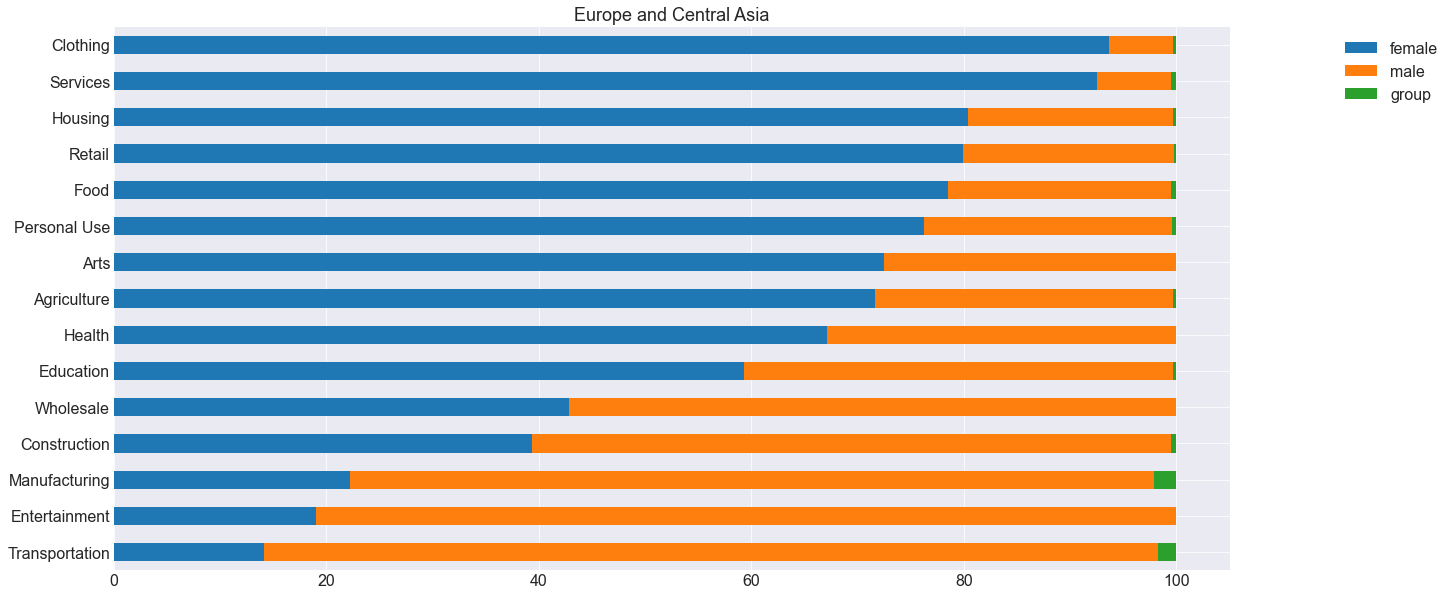

In [36]:
df_mpi_sector = df_mpi[['country', 'world_region']]
df_kiva_sector = df_kiva_loans[['country', 'borrower_genders', 'sector']]
df_kiva_sector = df_kiva_sector.merge(df_mpi_sector, how='left', on='country')
df_kiva_sector['borrower_genders'] = [elem if elem in ['female','male']\
                                    else 'group' for elem in df_kiva_sector['borrower_genders']]

regions = df_kiva_sector['world_region'].dropna().unique().tolist()
sectors = df_kiva_sector['sector'].value_counts()

for i in range(len(regions)):
    df_kiva_sector_un = df_kiva_sector
    df_kiva_sector_un = df_kiva_sector_un[df_kiva_sector_un['world_region'] == regions[i]]

    df_kiva_sector_un = df_kiva_sector_un[df_kiva_sector_un['sector'].isin(sectors.index.values)]\
        .groupby(['sector', 'borrower_genders'])['borrower_genders']\
        .count()\
        .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
        .unstack('borrower_genders')\
        .fillna(0)\
        .sort_values(by=['female', 'male'])[-15:]

    df_kiva_sector_un = df_kiva_sector_un[['female', 'male', 'group']]
    plot = df_kiva_sector_un.plot.barh(
                figsize=(20,10)
                , fontsize=16
                , stacked=True
                , title=regions[i])
    plot.title.set_size(18)
    plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
    plot.set(ylabel=None, xlabel=None)
    plt.show()


В арабских странах женщины имеют абсолютное большинство в займах на искусство, в остальных секторах присутствуют незначительно.
В Азии подавляющее большинство заемщиков - женщины. Предпочтительные сектора: развлечения, транспорт,сервис,искусство,сервис,одежда,розница. В африканских странах женщин заемщиков не намного больше, чем мужчин. Превышают  в секторах: искусство, сервис, одежда, розница. И в латиноамериканском регионе примерно равное распределение займов между мужчинами и женщинами. Женщины преобладают в секторах: Образование, розница и продовольствие


# 4.2.2
Влияние такого атрибута займа, как Количество кредиторов (lender_count), на суммы и сроки займов.

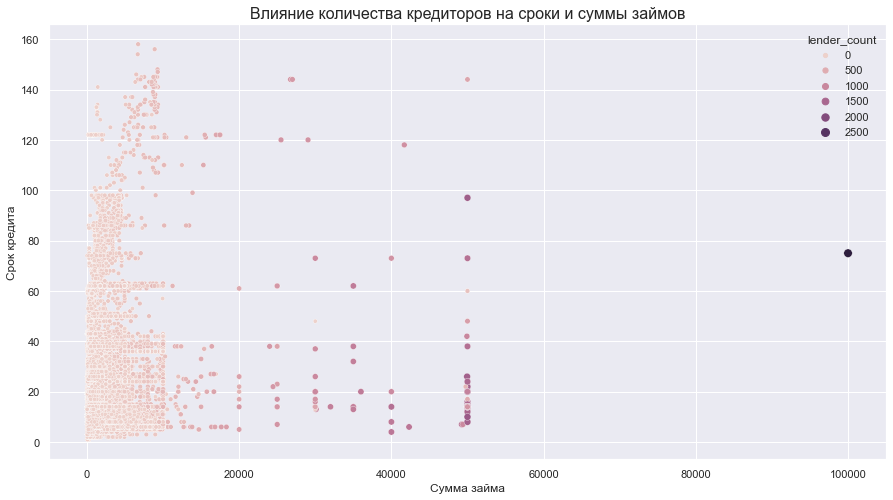

In [36]:
loan_lender = df_kiva_loans[['loan_amount','lender_count', 'term_in_months']]

fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(data=loan_lender, x='loan_amount', y='term_in_months', hue='lender_count', size='lender_count', ax=ax)

ax.set_title('Влияние количества кредиторов на сроки и суммы займов', fontsize=16)
ax.set_xlabel('Cумма займа')
ax.set_ylabel('Срок кредита')

plt.show()

In [32]:
#Но в 4.2.2 также, как идея, удобно было бы посмотреть медиану по срокам выплаты и сумме займа,
#разбив значения на группы, допустим, таким образом:

bins = [0, 3, 7, 12, 23, 100, 268]


dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
std = df_kiva_loans['loan_amount'].std()
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

df_kiva_loans_trimmed['binned'] = pd.cut(df_kiva_loans_trimmed['lender_count'], bins=bins)
df_kiva_loans_trimmed = df_kiva_loans_trimmed[['loan_amount','lender_count', 'term_in_months', 'binned']]

df_kiva_loans_trimmed = df_kiva_loans_trimmed.sort_values(by='binned')

df_kiva_loans_trimmed.head()

<ipython-input-32-28a465277ec3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kiva_loans_trimmed['binned'] = pd.cut(df_kiva_loans_trimmed['lender_count'], bins=bins)


,loan_amount,lender_count,term_in_months,binned
671201,25.0,1,13.0,"(0, 3]"
452573,225.0,1,7.0,"(0, 3]"
580613,200.0,1,8.0,"(0, 3]"
157191,75.0,2,14.0,"(0, 3]"
254156,225.0,3,7.0,"(0, 3]"


На графике отчетливо видно, что количество кредиторов совершенно не влияет на сроки кредитования, но прослеживается зависимость количества кредиторов от суммы. Чем больше сумма, тем больше кредиторов.

# 4.2.3
Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

In [10]:
df_mpi_mpi = df_mpi[['country', 'MPI']]
df_kiva_mpi = df_kiva_loans[['country', 'term_in_months', 'loan_amount']]
df_kiva_mpi = df_kiva_mpi.merge(df_mpi_mpi, how='left', on='country')


In [11]:
df_kiva_mpi = df_kiva_mpi.sort_values(by='MPI')
df_kiva_mpi = df_kiva_mpi.dropna()
df_kiva_mpi = df_kiva_mpi[df_kiva_mpi['MPI'] != 0]
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)


In [12]:
df_kiva_mpi = df_kiva_mpi.groupby(['country'])\
              .agg({'loan_amount' : 'median', 'term_in_months' : 'median', 'MPI' : 'mean'}).reset_index()
df_kiva_mpi = df_kiva_mpi[df_kiva_mpi.country.isin(list_countries)].sort_values(by='MPI')


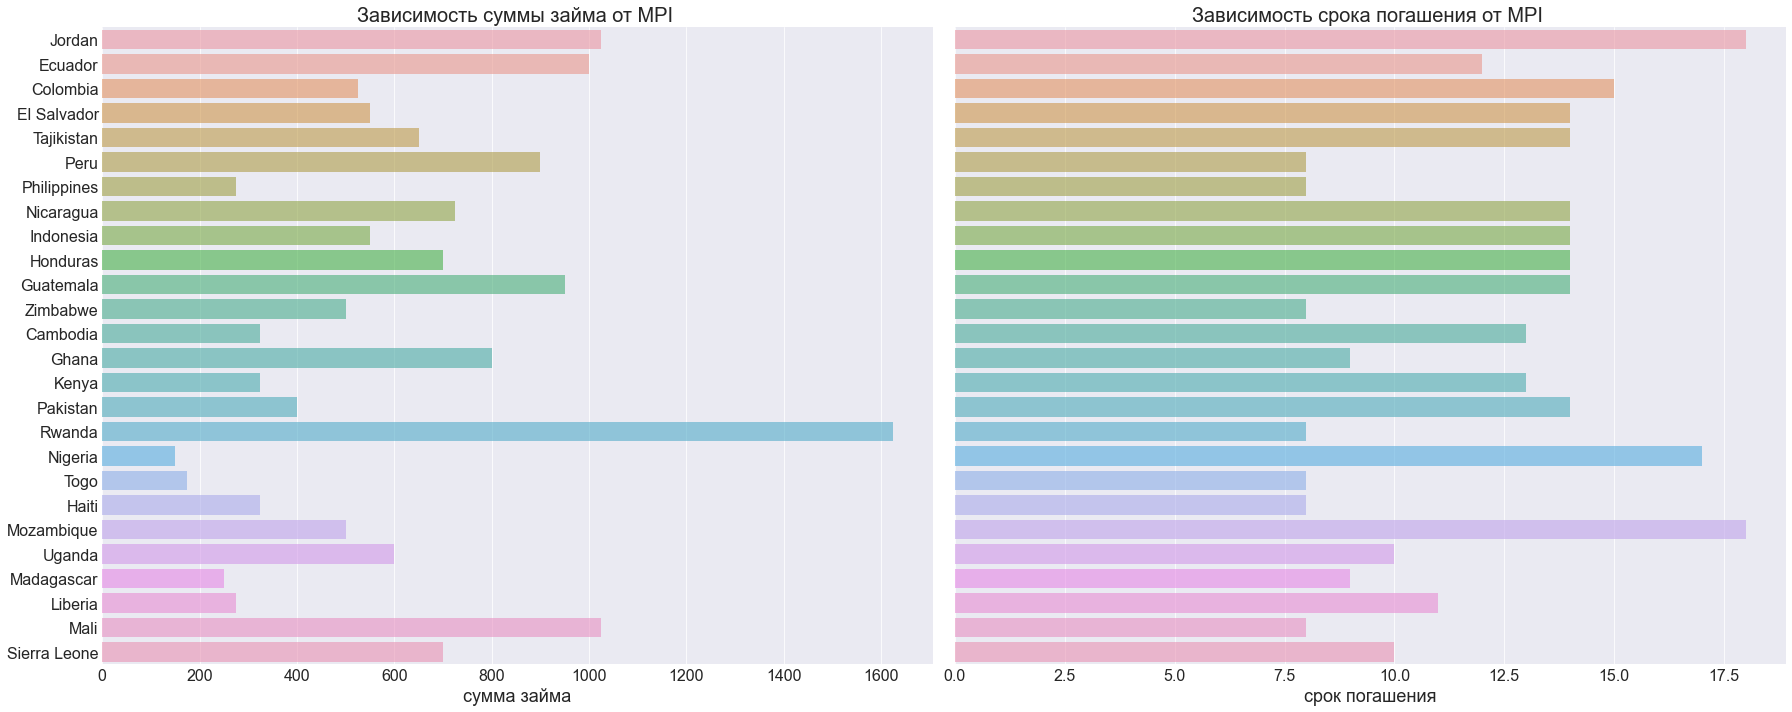

In [13]:
f,ax=plt.subplots(1, 2, sharey=True, figsize=(25,10))

sns.barplot(y='country', x='loan_amount', data=df_kiva_mpi, alpha=0.6, ax=ax[0])
ax[0].set_title("Зависимость суммы займа от MPI ", fontsize=20)
ax[0].set_xlabel('сумма займа', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='term_in_months', data=df_kiva_mpi, alpha=0.6, ax=ax[1])
ax[1].set_title("Зависимость срока погашения от MPI ", fontsize=20)
ax[1].set_xlabel('срок погашения', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

Из графиков видно что индекс бедности стран не влияет на сроки погашения и суммы займов

# 4.2.4
Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж»,
в разрезе макрорегионов.

In [5]:
df_mpi_macro = df_mpi[['country', 'world_region']]

# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

df_loans_dates_trimmed = df_loans_dates_trimmed[['country','loan_amount', 'time_funding', 'term_in_months']]
df_loans_dates_trimmed['monthly_repayment'] = df_loans_dates_trimmed['loan_amount'] / df_loans_dates_trimmed['term_in_months']

df_loans_dates_trimmed = df_loans_dates_trimmed.merge(df_mpi_macro, how='left', on='country')
df_loans_dates_trimmed = df_loans_dates_trimmed.dropna()

df_loans_dates_trimmed.head(3)


C:\Users\lenyev_yn\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\lenyev_yn\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\lenyev_yn\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,country,loan_amount,time_funding,term_in_months,monthly_repayment,world_region
0,Kenya,250.0,28.650336,4.0,62.5,Sub-Saharan Africa
1,Kenya,250.0,28.650336,4.0,62.5,Sub-Saharan Africa
2,Kenya,250.0,28.650336,4.0,62.5,Sub-Saharan Africa


In [20]:
df_loans_dates_trimmed = df_loans_dates_trimmed.groupby(['world_region'])\
       .agg({'loan_amount' : 'median', 'term_in_months' : 'median', 'time_funding' : 'median', 'monthly_repayment' : 'median'})\
       .reset_index()
df_loans_dates_trimmed

,world_region,loan_amount,term_in_months,time_funding,monthly_repayment
0,Arab States,650.0,14.0,3.765104,46.428571
1,East Asia and the Pacific,575.0,10.0,9.967639,52.272727
2,Europe and Central Asia,775.0,14.0,14.089433,30.769231
3,Latin America and Caribbean,750.0,12.0,20.531019,62.500000
4,South Asia,750.0,14.0,7.376806,35.714286
5,Sub-Saharan Africa,225.0,14.0,13.704745,17.857143


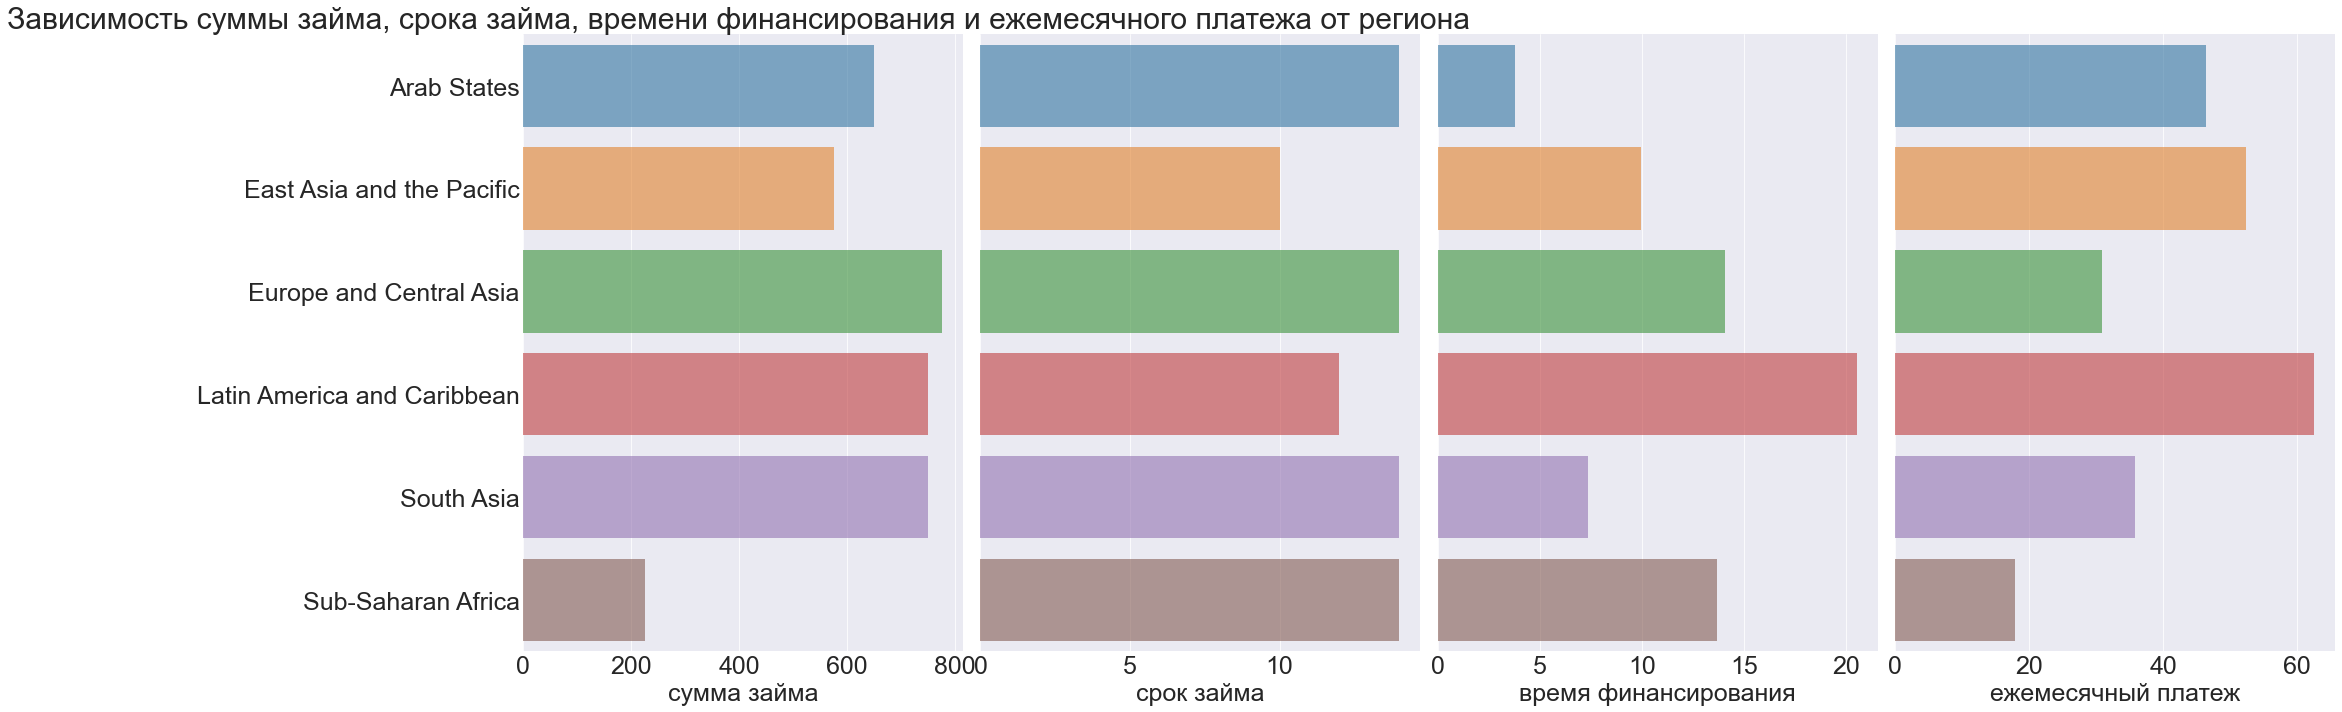

In [71]:
f,ax=plt.subplots(1, 4, sharey=True, figsize=(30,10))

sns.barplot(y='world_region', x='loan_amount', data=df_loans_dates_trimmed, alpha=0.6, ax=ax[0])
ax[0].set_title("Зависимость суммы займа, срока займа, времени финансирования и ежемесячного платежа от региона "\
                , fontsize=30)
ax[0].set_xlabel('сумма займа', fontsize=25)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=25)

sns.barplot(y='world_region', x='term_in_months', data=df_loans_dates_trimmed, alpha=0.6, ax=ax[1])
ax[1].set_xlabel('срок займа', fontsize=25)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=25)

sns.barplot(y='world_region', x='time_funding', data=df_loans_dates_trimmed, alpha=0.6, ax=ax[2])
ax[2].set_xlabel('время финансирования', fontsize=25)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=25)

sns.barplot(y='world_region', x='monthly_repayment', data=df_loans_dates_trimmed, alpha=0.6, ax=ax[3])
ax[3].set_xlabel('ежемесячный платеж', fontsize=25)
ax[3].set_ylabel(None)
ax[3].tick_params(labelsize=25)

plt.tight_layout()
plt.show()

Анализируя графики можно сделать выводы:
1. Сроки займа незначительно отличаются в разных регионах( за исключением Восточной Азии и стран Тихого океана. 
   Здесь они минимальны)
2. Суммы займов минимальны в странах Африки
3. Время финансирования заявки значительно меньше в арабских странах по сравнению с другими регионами
4. Ежемесячный платеж зависит от суммы заявки и мрока займа, поэтому также минимальный в странах Африки
5. В странах Латинской Америки большие суммы займов и время финансирования
